# <a id='toc1_'></a>[Temperature analysis](#toc0_)

**Table of contents**<a id='toc0_'></a>    
- [Temperature analysis](#toc1_)    
  - [Introduction](#toc1_1_)    
  - [Imports](#toc1_2_)    
  - [Load data](#toc1_3_)    
  - [Background removing](#toc1_4_)    
  - [Calculation of the vibrational temperature](#toc1_5_)    
  - [Calculation of the rotational temperature - By analysing the R branch](#toc1_6_)    
    - [Verification](#toc1_6_1_)    
  - [Calculation of the rotational temperature - By fitting with the simulation spectrum](#toc1_7_)    
  - [Influence of different parameters on the fit](#toc1_8_)    
- [Conclusion](#toc2_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_1_'></a>[Introduction](#toc0_)

This notebook provides a comprehensive analysis of temperature measurements derived from spectral data. The workflow includes loading and preprocessing the data, identifying key spectral features, and calculating vibrational and rotational temperatures using both analytical methods and simulation-based fitting. The results are then visualized and compared to assess the accuracy and reliability of the methods.



## <a id='toc1_2_'></a>[Imports](#toc0_)

In [1]:
# %matplotlib ipympl # for interactive plots

import imageio.v2 as imageio
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import pandas as pd
import os

In [2]:
import sys
sys.path.append("../src")


import xspectra.simulation as sim 
import xspectra.utils as utils 
import xspectra.visualization as vis 

## <a id='toc1_3_'></a>[Load data](#toc0_)

In [3]:
folder_data = "data/temperature_analysis"
datas = np.array([np.loadtxt(os.path.join(folder_data, d), delimiter="\t") for d in os.listdir(folder_data) if d.endswith(".txt")])
datas.shape

(3, 1024, 2)

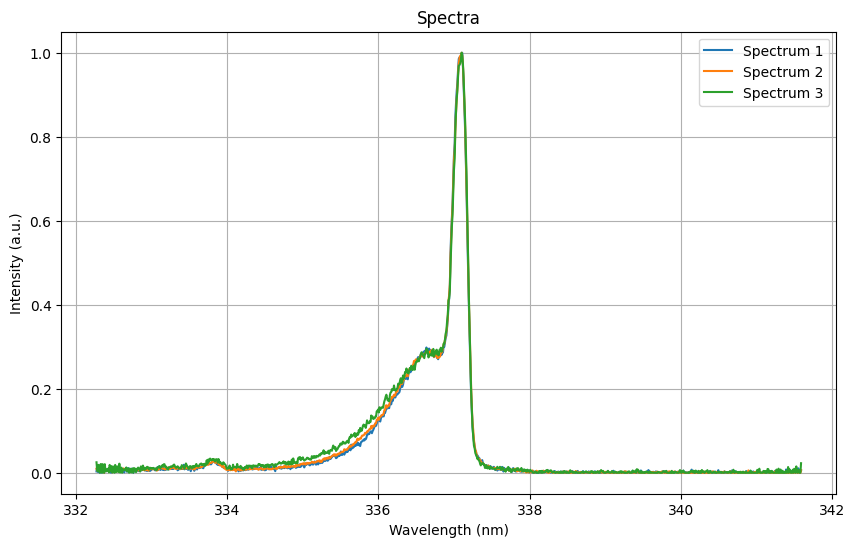

In [4]:
plt.figure(figsize=(10, 6))

for i, data in enumerate(datas):
    plt.plot(data[:, 0], data[:, 1], label=f'Spectrum {i + 1}')

plt.xlabel('Wavelength (nm)')
plt.ylabel('Intensity (a.u.)')
plt.title('Spectra')
plt.legend()
plt.grid()
plt.show()

## <a id='toc1_4_'></a>[Background removing](#toc0_)

In [5]:
for i, data in enumerate(datas):
    datas[i] = utils.delete_background(data)

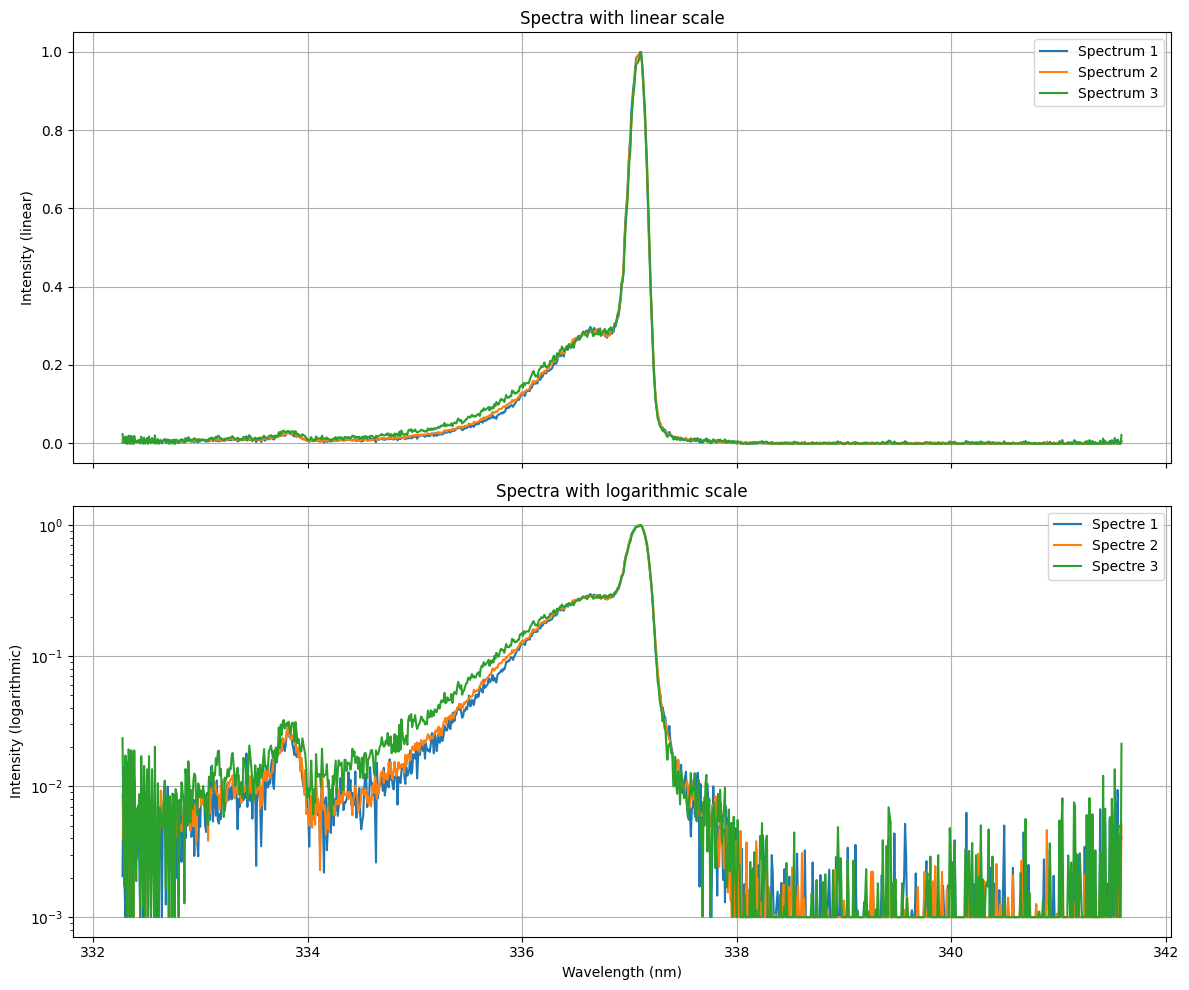

In [6]:
fig, axs = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Graphique avec échelle linéaire
for i, data in enumerate(datas):
    axs[0].plot(data[:, 0], data[:, 1], label=f'Spectrum {i + 1}')
axs[0].set_ylabel('Intensity (linear)')
axs[0].set_title('Spectra with linear scale')
axs[0].legend()
axs[0].grid()

# Graphique avec échelle logarithmique
epsilon = 1e-3
for i, data in enumerate(datas):
    axs[1].plot(data[:, 0], [x if x > epsilon else epsilon for x in data[:, 1]], label=f'Spectre {i + 1}')
axs[1].set_yscale('log')
axs[1].set_xlabel('Wavelength (nm)')
axs[1].set_ylabel('Intensity (logarithmic)')
axs[1].set_title('Spectra with logarithmic scale')
axs[1].legend()
axs[1].grid()

plt.tight_layout()
plt.show()

## <a id='toc1_5_'></a>[Calculation of the vibrational temperature](#toc0_)

We identify the dominant peak at $337.5 \, nm$ as well as secondary peaks. We take $334.44 \, nm$ as the second reference.

Looking at the theoretical spectrum, we obtain that:
- the dominant peak at $\lambda_1 = 337.5 \, nm$ corresponds to the transition $C^3\Pi(\nu'=0) \rightarrow B^3 \Pi_g(\nu''=0)$
- the dominant peak at $\lambda_2 = 334.44 \, nm$ corresponds to the transition $C^3\Pi(\nu'=1) \rightarrow B^3 \Pi_g(\nu''=1)$

Following the theoretical formulas developed in the [simulation jupyter notebook](../simulation_diazote.ipynb), we have the following emission ratio:

$$\displaystyle r=\frac{\epsilon_1}{\epsilon_2}=\frac{q_1 n_1 \nu_1}{q_2 n_2 \nu_2} = \frac{q_1g_{e1}(2J_1+1)e^{-\frac{T_{e1}}{kT_{el}}-\frac{G(\nu_1)}{kT_{vib}}-\frac{F(J_1)}{kT_{rot}}}}{q_2g_{e2}(2J_2+1)e^{-\frac{T_{e2}}{kT_{el}}-\frac{G(\nu_2)}{kT_{vib}}-\frac{F(J_2)}{kT_{rot}}}}\frac{\nu_1}{\nu_2}$$

By eliminating the electronic degeneracies, which are equal, as well as the effect of rotations, we arrive at:
$$\displaystyle r_{12}= \frac{q_1\nu_1}{q_2\nu_2} \exp \left(\frac{T_{e2}-T_{e1}}{kT_{el}}+\frac{G(\nu_2)-G(\nu_1)}{kT_{vib}}\right)$$

Then, since we start from the same electrical energy level for both ($C^3\Pi$), we have $T_{e1}=T_{e2}$, hence:

$$\displaystyle r_{12}= \frac{q_1\nu_1}{q_2\nu_2} \exp \left(\frac{G(\nu_2)-G(\nu_1)}{kT_{vib}}\right)$$

Otherwise, we can use a third peak: $\lambda_3 = 331.735 \, nm$ corresponding to the transition $C^3\Pi(\nu'=2) \rightarrow B^3 \Pi_g(\nu''=2)$ to find the two unknowns.

We don't have a clear enough spectrum to look at the rotational levels.

$$T_{vib} = \frac{G(\nu_2) - G(\nu_1)}{k \ln\left(r_{12} \cdot \frac{\lambda_1 q_2}{\lambda_2 q_1}\right)}$$

Using the wavelength values $\nu_1 = 337.5 \, nm$ and $\nu_2 = 334.44 \, nm$, as well as the ratio $r_{12}$ calculated from the intensities of the corresponding peaks in the measured spectrum, we can determine $T_{vib}$.

Theoretically, $G(\nu_2=1) - G(\nu_1=0)=5.973\times10^{-20}-2.019\times10^{-20}\,J=3.954\times10^{-20}J$

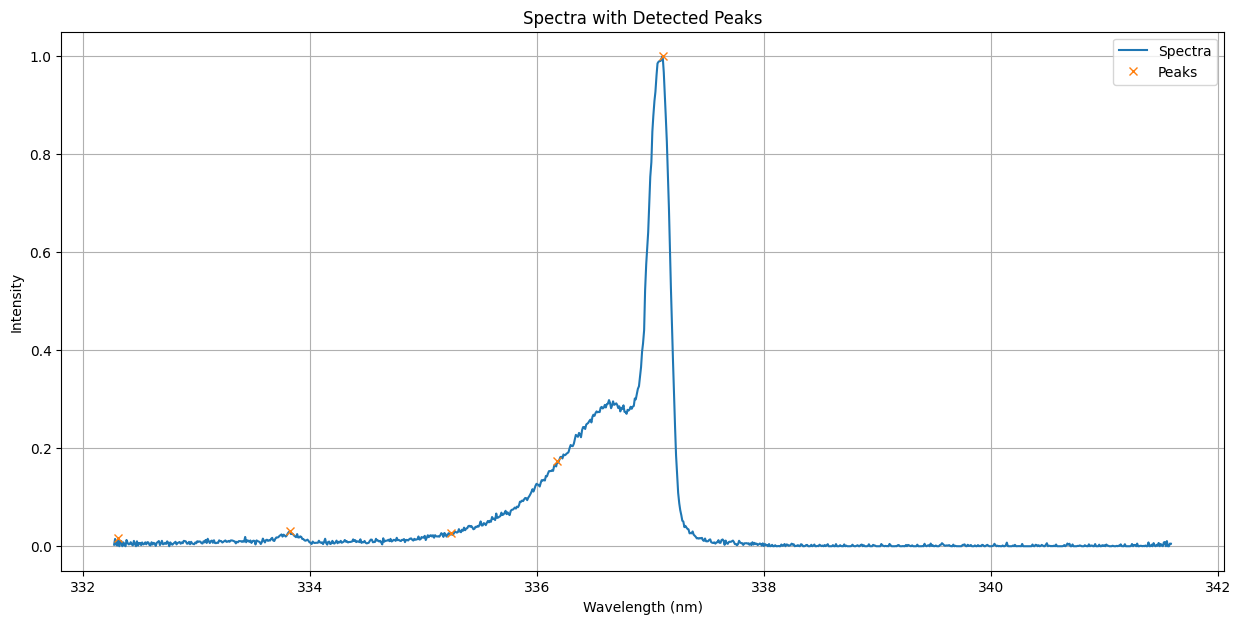

Index of the peaks : [  4 169 324 427 529]
Detected peaks at wavelengths: [332.31041 333.8222  335.23876 336.17808 337.10659]


In [7]:
from scipy.signal import find_peaks

peaks, _ = find_peaks(datas[0,:,1], height=0.01, distance=100)

# Afficher les résultats
plt.figure(figsize=(15, 7))
plt.plot(datas[0,:,0], datas[0,:,1], label="Spectra")
plt.plot(datas[0,peaks,0], datas[0,peaks,1], "x", label="Peaks")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Intensity")
plt.title("Spectra with Detected Peaks")
plt.legend()
plt.grid()
plt.show()

# Afficher les longueurs d'onde des pics détectés
print(f"Index of the peaks : {peaks}")
print("Detected peaks at wavelengths:", datas[0,peaks,0])

We can get automatically get the two index of the main transitions.

In [8]:
i_primary, i_secondary = utils.find_index_primary_peaks(datas[0,:,0], datas[0,:,1], height=0.01, distance=100)
print(f"Index of the primary peaks   : {i_primary:3d}   - Wavelengths : {datas[0,i_primary,0]:3.2f}")
print(f"Index of the secondary peaks : {i_secondary:3d}   - Wavelengths : {datas[0,i_secondary,0]:3.2f}")

Index of the primary peaks   : 529   - Wavelengths : 337.11
Index of the secondary peaks : 169   - Wavelengths : 333.82


We note the indices of the lines that interest us:
- $i=529$ for the line $\nu'=0\leftrightarrow\nu''=0$
- $i=169$ for the line $\nu'=1\leftrightarrow\nu''=1$

In [9]:
T_vib_ratio = [utils.compute_t_vib_by_ratio(data[:,1], i1=i_primary, i2=i_secondary) for data in datas]

for i, t in enumerate(T_vib_ratio):
    print(f"Temperature for spectrum {i + 1}: {t:.0f} K")

Temperature for spectrum 1: 5167 K
Temperature for spectrum 2: 5942 K
Temperature for spectrum 3: 5983 K


Here are the vibrational temperatures of the three spectra:

- Temperature for spectrum 1: 808 K
- Temperature for spectrum 2: 825 K
- Temperature for spectrum 3: 826 K

## <a id='toc1_6_'></a>[Calculation of the rotational temperature - By analysing the R branch](#toc0_)

In [10]:
T_rot_R_branch = [utils.compute_Trot_with_branch(data[:,0], data[:,1], J_range=(8, 20), certainty=0.95) for data in datas]

for i, t in enumerate(T_rot_R_branch):
    print(f"Temperature for spectrum {i + 1}: {t[0]:.0f} +/- {t[1]:.0f} K")

Temperature for spectrum 1: 302 +/- 14 K
Temperature for spectrum 2: 312 +/- 8 K
Temperature for spectrum 3: 363 +/- 16 K


### <a id='toc1_6_1_'></a>[Verification](#toc0_)
We van verify the regression by plotting it

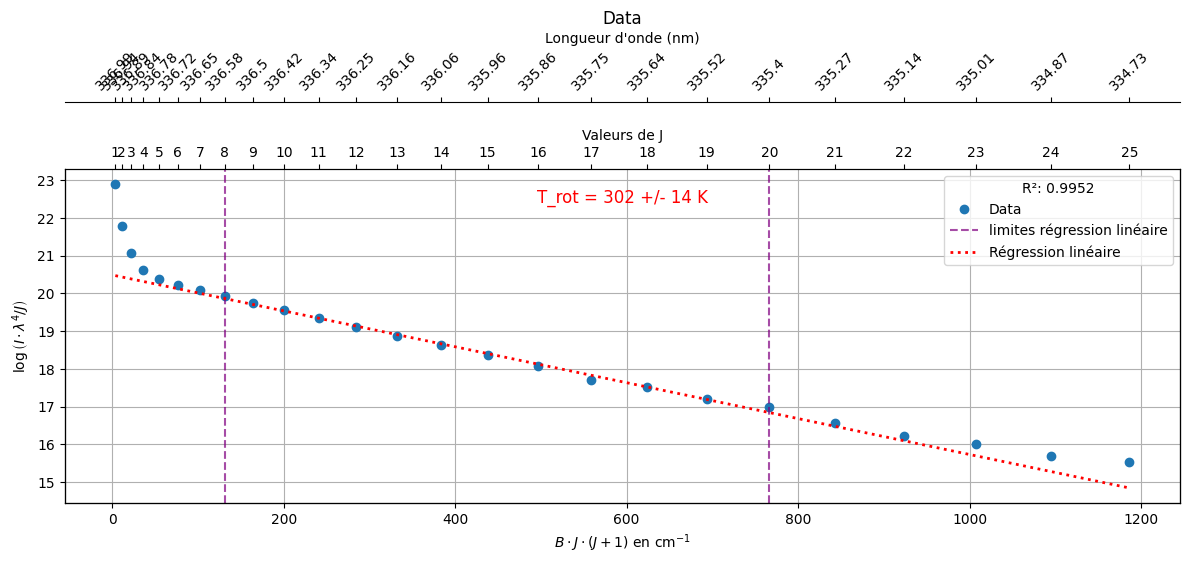

In [11]:
# vis.show_result_calculation_Trot(datas[0,:,0], datas[0,:,1], J_range=(8, 20), certainty=0.95, output_file="./res/Trot_R_branch.png")
vis.show_result_calculation_Trot(datas[0,:,0], datas[0,:,1], J_range=(8, 20), certainty=0.95)

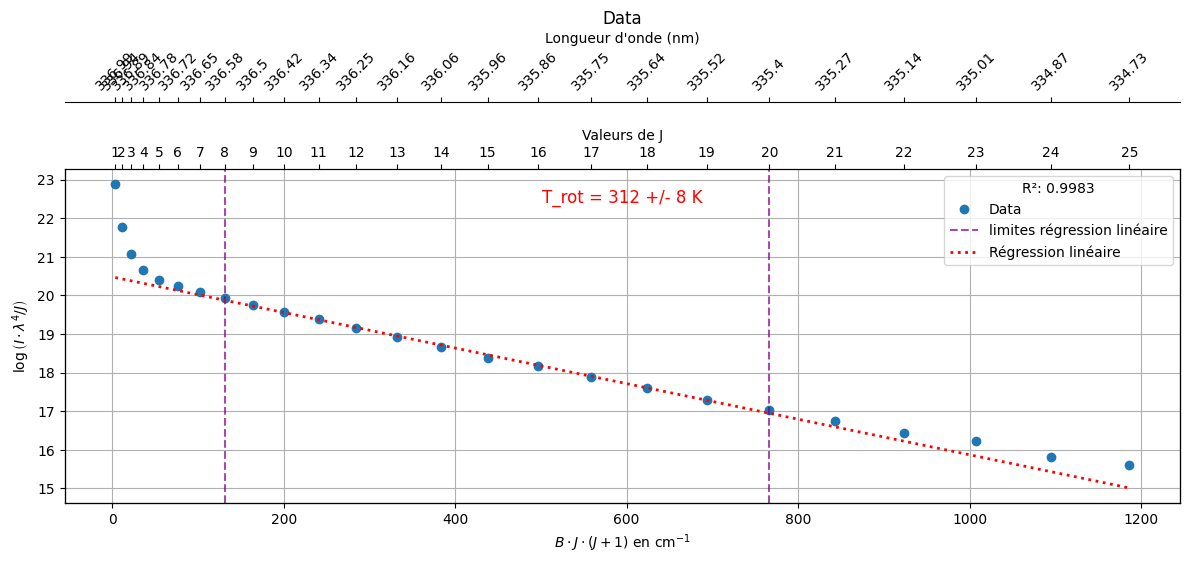

In [12]:
vis.show_result_calculation_Trot(datas[1,:,0], datas[1,:,1], J_range=(8, 20), certainty=0.95)


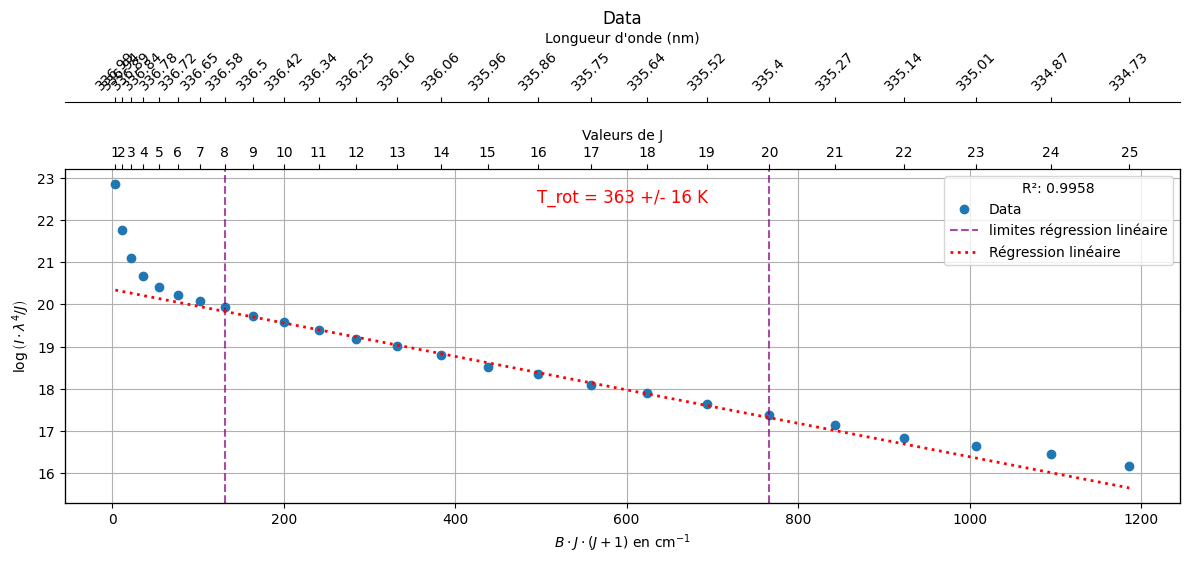

In [13]:
vis.show_result_calculation_Trot(datas[2,:,0], datas[2,:,1], J_range=(8, 20), certainty=0.95)

## <a id='toc1_7_'></a>[Calculation of the rotational temperature - By fitting with the simulation spectrum](#toc0_)

In [14]:
llims = (335.3, 338)
masks = (llims[0] <= datas[:, :, 0] ) & (datas[:, :, 0] <= llims[1])      

In [15]:
def find_wavelenth_deviation(wavelength, spectrum):
    MAXIMUM_SIMULATION_SPECTUM = 337.18 # nm
    return MAXIMUM_SIMULATION_SPECTUM-wavelength[spectrum.argmax()]

In [16]:
decalage_vs_simulation = find_wavelenth_deviation(datas[0, :, 0], datas[0, :, 1])
decalage_vs_simulation

np.float64(0.07341000000002396)

In [17]:
decalage_vs_simulation = 0.1 # Or you can fix it manually (you can even make it trainable for the fit - check bellow)

In [18]:
# Calcul du spectre de simulation 
T_rot_assumption = [t[0] for t in T_rot_R_branch]
# T_rot_assumption = [255,265,305] # données du fit plus bas
simulation_spectrum = [sim.get_spectrum(datas[0, :, 0]+decalage_vs_simulation, T_el=1_000, T_vib=T_vib_ratio[0], T_rot=T_rot_assumption[i], sigma_exp=0.09) for i in range(3)]

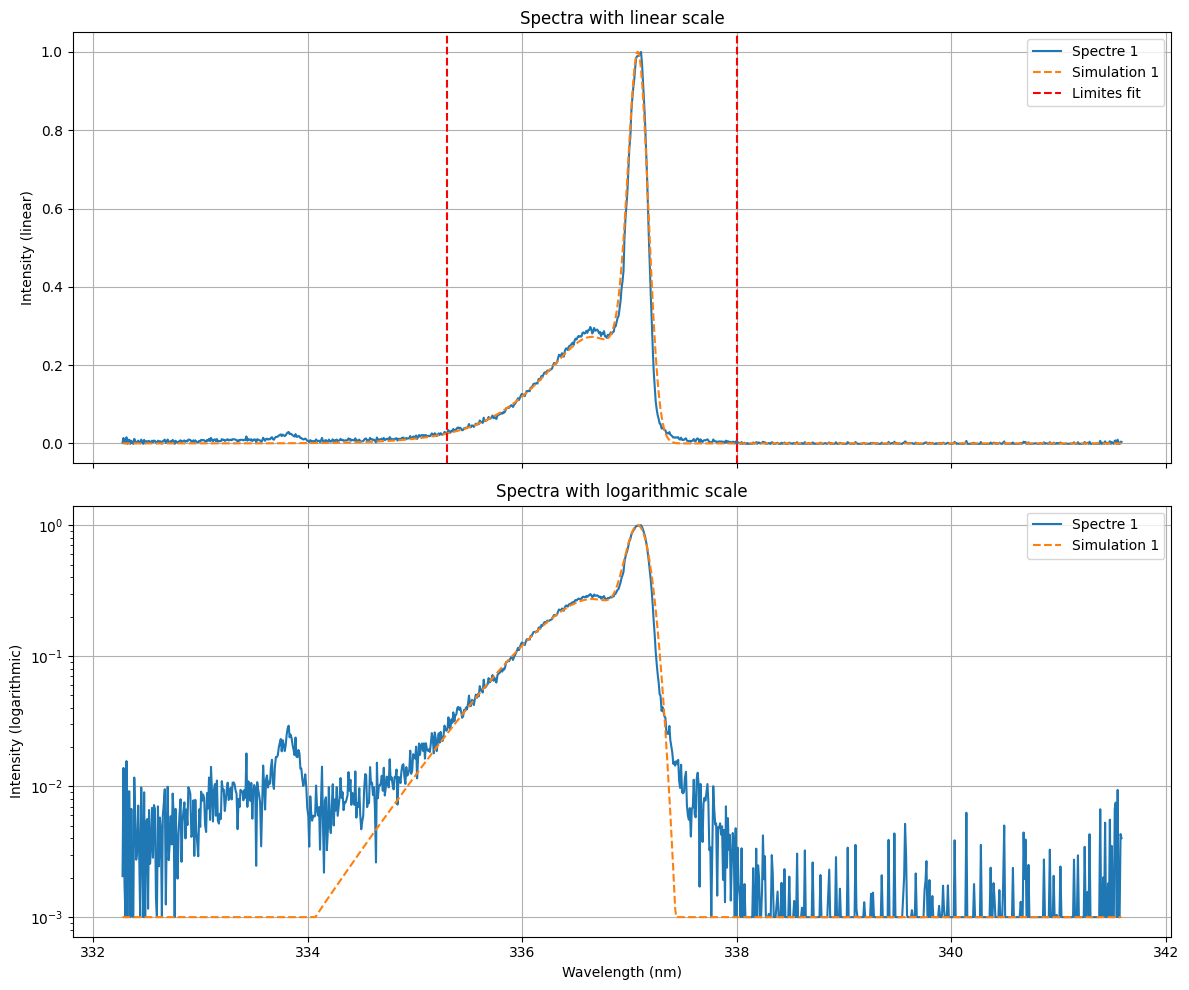

In [19]:
fig, axs = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Graphique avec échelle linéaire
for i, data in enumerate([datas[0]]):
    axs[0].plot(data[:, 0], data[:, 1], label=f'Spectre {i + 1}')
    axs[0].plot(datas[0, :, 0], simulation_spectrum[i], label=f'Simulation {i+1}', linestyle='--')

axs[0].axvline(x=llims[0], color='r', linestyle='--', label='Limites fit')
axs[0].axvline(x=llims[1], color='r', linestyle='--')    

axs[0].set_ylabel('Intensity (linear)')
axs[0].set_title('Spectra with linear scale')
axs[0].legend()
axs[0].grid()

# Graphique avec échelle logarithmique
epsilon = 1e-3
for i, data in enumerate([datas[0]]):
    axs[1].plot(data[:, 0], [x if x > epsilon else epsilon for x in data[:, 1]], label=f'Spectre {i + 1}')
    axs[1].plot(datas[0, :, 0], [x if x > epsilon else epsilon for x in simulation_spectrum[i]], label=f'Simulation {i+1}', linestyle='--')
axs[1].set_yscale('log')
axs[1].set_xlabel('Wavelength (nm)')
axs[1].set_ylabel('Intensity (logarithmic)')
axs[1].set_title('Spectra with logarithmic scale')
axs[1].legend()
axs[1].grid()

plt.tight_layout()
plt.savefig("./res/spectrum_simulation.png")
plt.show()


In [20]:
T_rot_sim = np.zeros(len(datas))
elargissement_sim = np.zeros(len(datas))
decalage_sim = np.zeros(len(datas))

for i, data in enumerate(datas):
    s, _, t, elargissement, decalage, _ = utils.get_best_fit(data[masks[0],0], data[masks[0],1], 
                                 T_vib=T_vib_ratio[0],
                                 elargissement=0.1,
                                 w_decalage=0,
                                T_rot_range=(100, 1_200),
                                elargissement_range=(0.05,0.12),
                                w_decalage_range=(-2, 2),
                                verbose=True, 
                                nb_steps=5)
    print()
    
    T_rot_sim[i] = t
    elargissement_sim[i] = elargissement
    decalage_sim[i] = decalage

Iteration   1 | Score:    1.638 | Elargissement:   0.10 nm | T_vib =   5167 | T_rot:    570 K | Scale 1.00000000 | Décalage: 0.0904 nm
Iteration   2 | Score:    0.494 | Elargissement:   0.10 nm | T_vib =   5167 | T_rot:    282 K | Scale 1.00000000 | Décalage: 0.1035 nm
Iteration   3 | Score:    0.477 | Elargissement:   0.10 nm | T_vib =   5167 | T_rot:    256 K | Scale 1.00000000 | Décalage: 0.1047 nm
Iteration   4 | Score:    0.477 | Elargissement:   0.10 nm | T_vib =   5167 | T_rot:    254 K | Scale 1.00000000 | Décalage: 0.1048 nm
Iteration   5 | Score:    0.477 | Elargissement:   0.10 nm | T_vib =   5167 | T_rot:    253 K | Scale 1.00000000 | Décalage: 0.1048 nm

Iteration   1 | Score:    1.534 | Elargissement:   0.10 nm | T_vib =   5167 | T_rot:    580 K | Scale 1.00000000 | Décalage: 0.0888 nm
Iteration   2 | Score:    0.472 | Elargissement:   0.10 nm | T_vib =   5167 | T_rot:    295 K | Scale 1.00000000 | Décalage: 0.1014 nm
Iteration   3 | Score:    0.458 | Elargissement:   0.1

## <a id='toc1_8_'></a>[Influence of different parameters on the fit](#toc0_)

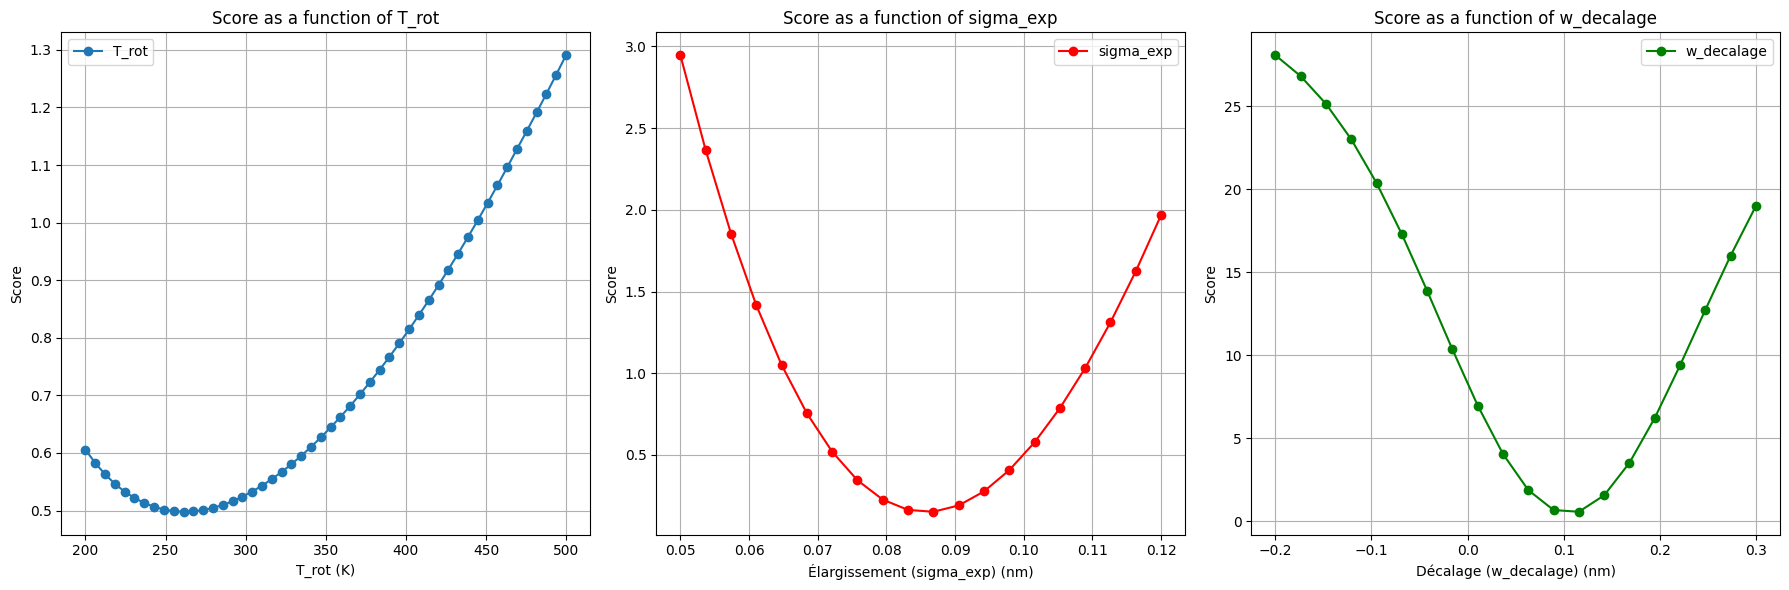

In [21]:
# Calculer les scores pour chaque valeur de T_rot
T_rot_range = np.linspace(200, 500, 50)
sigma_exp_range = np.linspace(0.05, 0.12, 20)
w_decalage_range = np.linspace(-0.2, 0.3, 20)

filtered_wavelengths_target = datas[0, masks[0], 0]
filtered_spectrum_target = datas[0, masks[0], 1]

scores_T_rot = np.zeros_like(T_rot_range)
scores_sigma_exp = np.zeros_like(sigma_exp_range)
scores_w_decalage = np.zeros_like(w_decalage_range)

for idx, T_rot in enumerate(T_rot_range):
    scores_T_rot[idx] = utils.compute_score_fit(
        filtered_spectrum_target,
        sim.get_spectrum(filtered_wavelengths_target + decalage_vs_simulation, T_el=T_vib_ratio[0], T_rot=T_rot, sigma_exp=0.1)
    )

for idx, sigma_exp in enumerate(sigma_exp_range):
    scores_sigma_exp[idx] = utils.compute_score_fit(
        filtered_spectrum_target,
        sim.get_spectrum(filtered_wavelengths_target + decalage_vs_simulation, T_el=T_vib_ratio[0], T_rot=T_rot_sim[0], sigma_exp=sigma_exp)
    )

for idx, w_decalage in enumerate(w_decalage_range):
    scores_w_decalage[idx] = utils.compute_score_fit(
        filtered_spectrum_target,
        sim.get_spectrum(filtered_wavelengths_target + w_decalage, T_el=T_vib_ratio[0], T_rot=T_rot_sim[0], sigma_exp=0.1)
    )

# Tracer le graphe
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

axs[0].plot(T_rot_range, scores_T_rot, marker='o', label="T_rot")
axs[0].set_xlabel("T_rot (K)")
axs[0].set_ylabel("Score")
axs[0].set_title("Score as a function of T_rot")
axs[0].grid()
axs[0].legend()

axs[1].plot(sigma_exp_range, scores_sigma_exp, marker='o', label="sigma_exp", color='red')
axs[1].set_xlabel("Élargissement (sigma_exp) (nm)")
axs[1].set_ylabel("Score")
axs[1].set_title("Score as a function of sigma_exp")
axs[1].grid()
axs[1].legend()

axs[2].plot(w_decalage_range, scores_w_decalage, marker='o', label="w_decalage", color='green')
axs[2].set_xlabel("Décalage (w_decalage) (nm)")
axs[2].set_ylabel("Score")
axs[2].set_title("Score as a function of w_decalage")
axs[2].grid()
axs[2].legend()

plt.tight_layout()
plt.savefig("./res/scores_function.png", dpi=300, bbox_inches='tight')
plt.show()


The functions are all convexe and that justifies the trichotomy algorithm used to compute the minimum. 

We can even draw 3D graph for each combination.

In [22]:
from itertools import combinations

# Définir les plages de paramètres
T_rot_range = np.linspace(200, 500, 20)
sigma_exp_range = np.linspace(0.05, 0.12, 10)
w_decalage_range = np.linspace(-0.2, 0.3, 10)

# Paramètres à combiner
params = {
    "T_rot": T_rot_range,
    "sigma_exp": sigma_exp_range,
    "w_decalage": w_decalage_range
}

param_names = list(params.keys())

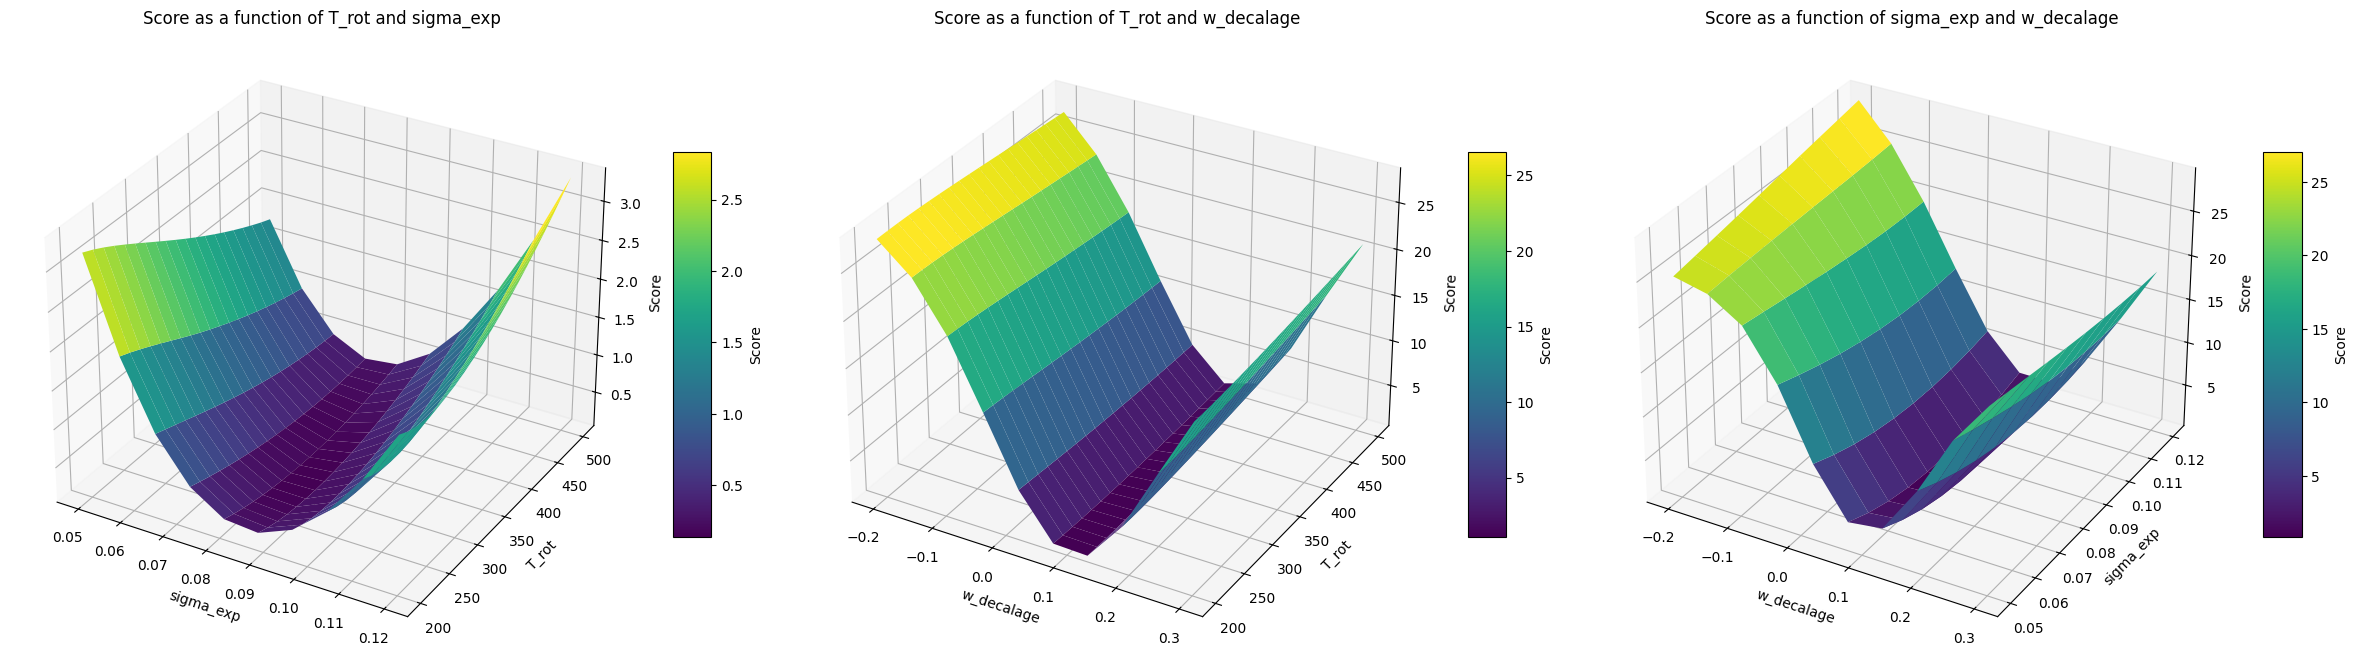

In [23]:
# Tracer les graphiques 3D alignés horizontalement
fig, axs = plt.subplots(1, 3, figsize=(24, 8), subplot_kw={'projection': '3d'})

# Générer toutes les combinaisons possibles de deux paramètres
for ax, (param1_name, param2_name) in zip(axs, combinations(param_names, 2)):
    param1_values = params[param1_name]
    param2_values = params[param2_name]

    # Initialiser une matrice pour stocker les scores
    scores = np.zeros((len(param1_values), len(param2_values)))

    # Calculer les scores pour chaque combinaison des deux paramètres
    for i, param1 in enumerate(param1_values):
        for j, param2 in enumerate(param2_values):
            # Définir les valeurs des paramètres en fonction de la combinaison actuelle
            kwargs = {param1_name: param1, param2_name: param2, "T_el": 1_000}
            
            # Définir les valeurs par défaut pour les paramètres non inclus dans la combinaison
            if param1_name != "T_rot" and param2_name != "T_rot":
                kwargs["T_rot"] = T_rot_sim[0]
            if param1_name != "sigma_exp" and param2_name != "sigma_exp":
                kwargs["sigma_exp"] = 0.1
            if param1_name != "w_decalage" and param2_name != "w_decalage":
                kwargs["w_decalage"] = decalage_vs_simulation
            
            # Calculer le score
            wavelengths = filtered_wavelengths_target + kwargs["w_decalage"]
            spectrum = sim.get_spectrum(wavelengths, T_el=kwargs["T_el"], T_rot=kwargs["T_rot"], sigma_exp=kwargs["sigma_exp"])
            scores[i, j] = utils.compute_score_fit(filtered_spectrum_target, spectrum)

    # Créer les grilles pour les paramètres
    param1_grid, param2_grid = np.meshgrid(param1_values, param2_values)

    # Tracer la surface
    surf = ax.plot_surface(param2_grid, param1_grid, scores.T, cmap='viridis', edgecolor='none')

    # Ajouter une barre de couleur
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, label='Score')

    # Ajouter des labels
    ax.set_xlabel(param2_name)
    ax.set_ylabel(param1_name)
    ax.set_zlabel('Score')
    ax.set_title(f'Score as a function of {param1_name} and {param2_name}')

plt.tight_layout()
plt.show()


On peut tenter un fit plus large et trouver $T_{vib}$

In [24]:
T_rot_sim = np.zeros(len(datas))
T_vib_sim = np.zeros(len(datas))
elargissement_sim = np.zeros(len(datas))
decalage_sim = np.zeros(len(datas))
scale_factor = np.zeros(len(datas))

# for i, data in enumerate([datas[0]]):
for i, data in enumerate(datas):
    s, t_vib, t_rot, elargissement, decalage, scale = utils.get_best_fit(data[:,0], data[:,1], 
                                 T_vib=1500,
                                 elargissement=0.1,
                                 w_decalage=0.1,
                                T_rot_range=(100, 1_200),
                                T_vib_range=(500, 8_000), # Il faut une plage assez grande pour que la fonction soit bien convexe
                                elargissement_range=(0.05,0.12),
                                w_decalage_range=(-2, 2),
                                w_scale_range=(0.999, 1.001), # ne pas trop grand sinon la fonction n'est pas convexe
                                modelisation_spectrum_function=sim.get_whole_spectrum, # cette fois-ci on génère les autres transitions vibrationnelles
                                verbose=True, 
                                nb_steps=4)
    print()
    
    T_vib_sim[i] = t_vib
    T_rot_sim[i] = t_rot
    elargissement_sim[i] = elargissement
    decalage_sim[i] = decalage
    scale_factor[i] = scale

Iteration   1 | Score:    0.512 | Elargissement:   0.09 nm | T_vib =    500 | T_rot:    266 K | Scale 1.00000000 | Décalage: 0.1034 nm
Iteration   2 | Score:    0.510 | Elargissement:   0.09 nm | T_vib =   3429 | T_rot:    259 K | Scale 0.99999999 | Décalage: 0.1037 nm
Iteration   3 | Score:    0.510 | Elargissement:   0.09 nm | T_vib =   3440 | T_rot:    259 K | Scale 0.99999998 | Décalage: 0.1037 nm
Iteration   4 | Score:    0.510 | Elargissement:   0.09 nm | T_vib =   3441 | T_rot:    259 K | Scale 0.99999998 | Décalage: 0.1037 nm

Iteration   1 | Score:    0.492 | Elargissement:   0.09 nm | T_vib =    500 | T_rot:    278 K | Scale 0.99999999 | Décalage: 0.1013 nm
Iteration   2 | Score:    0.492 | Elargissement:   0.09 nm | T_vib =   3695 | T_rot:    275 K | Scale 0.99999998 | Décalage: 0.1015 nm
Iteration   3 | Score:    0.492 | Elargissement:   0.09 nm | T_vib =   3703 | T_rot:    274 K | Scale 0.99999998 | Décalage: 0.1015 nm
Iteration   4 | Score:    0.492 | Elargissement:   0.0

In [25]:
simulation_spectrum_whole = [sim.get_whole_spectrum(scale_factor[i]*datas[0, :, 0]+decalage_sim[i], T_el=1_000, T_vib=T_vib_sim[i], T_rot=T_rot_sim[i], sigma_exp=elargissement_sim[i]) for i in range(3)]

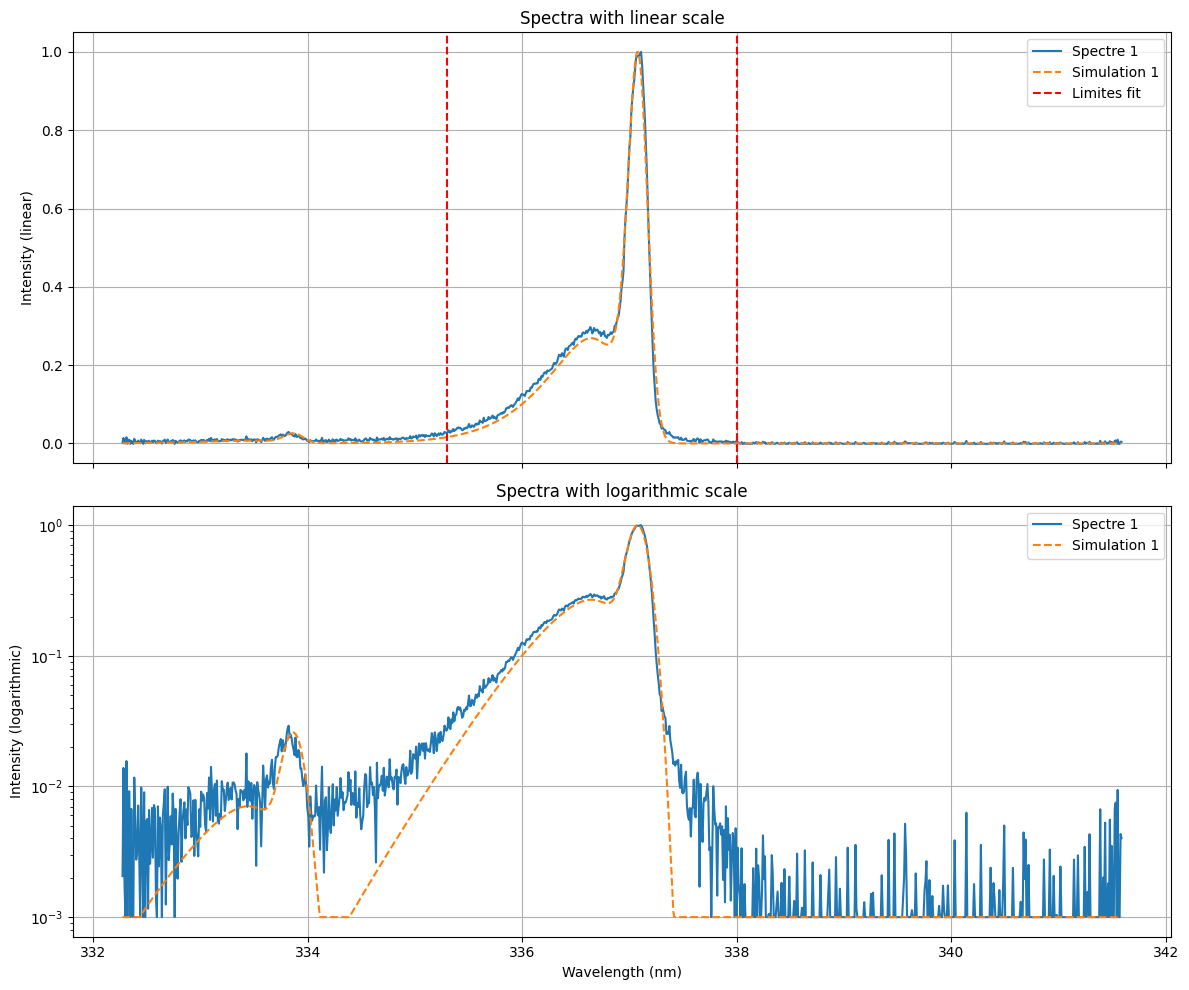

In [26]:
fig, axs = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Graphique avec échelle linéaire
for i, data in enumerate([datas[0]]):
    axs[0].plot(data[:, 0], data[:, 1], label=f'Spectre {i + 1}')
    axs[0].plot(datas[0, :, 0], simulation_spectrum_whole[i], label=f'Simulation {i+1}', linestyle='--')

axs[0].axvline(x=llims[0], color='r', linestyle='--', label='Limites fit')
axs[0].axvline(x=llims[1], color='r', linestyle='--')    

axs[0].set_ylabel('Intensity (linear)')
axs[0].set_title('Spectra with linear scale')
axs[0].legend()
axs[0].grid()

# Graphique avec échelle logarithmique
epsilon = 1e-3
for i, data in enumerate([datas[0]]):
    axs[1].plot(data[:, 0], [x if x > epsilon else epsilon for x in data[:, 1]], label=f'Spectre {i + 1}')
    axs[1].plot(datas[0, :, 0], [x if x > epsilon else epsilon for x in simulation_spectrum_whole[i]], label=f'Simulation {i+1}', linestyle='--')
axs[1].set_yscale('log')
axs[1].set_xlabel('Wavelength (nm)')
axs[1].set_ylabel('Intensity (logarithmic)')
axs[1].set_title('Spectra with logarithmic scale')
axs[1].legend()
axs[1].grid()

plt.tight_layout()
plt.savefig("./res/spectrum_simulation.png")
plt.show()


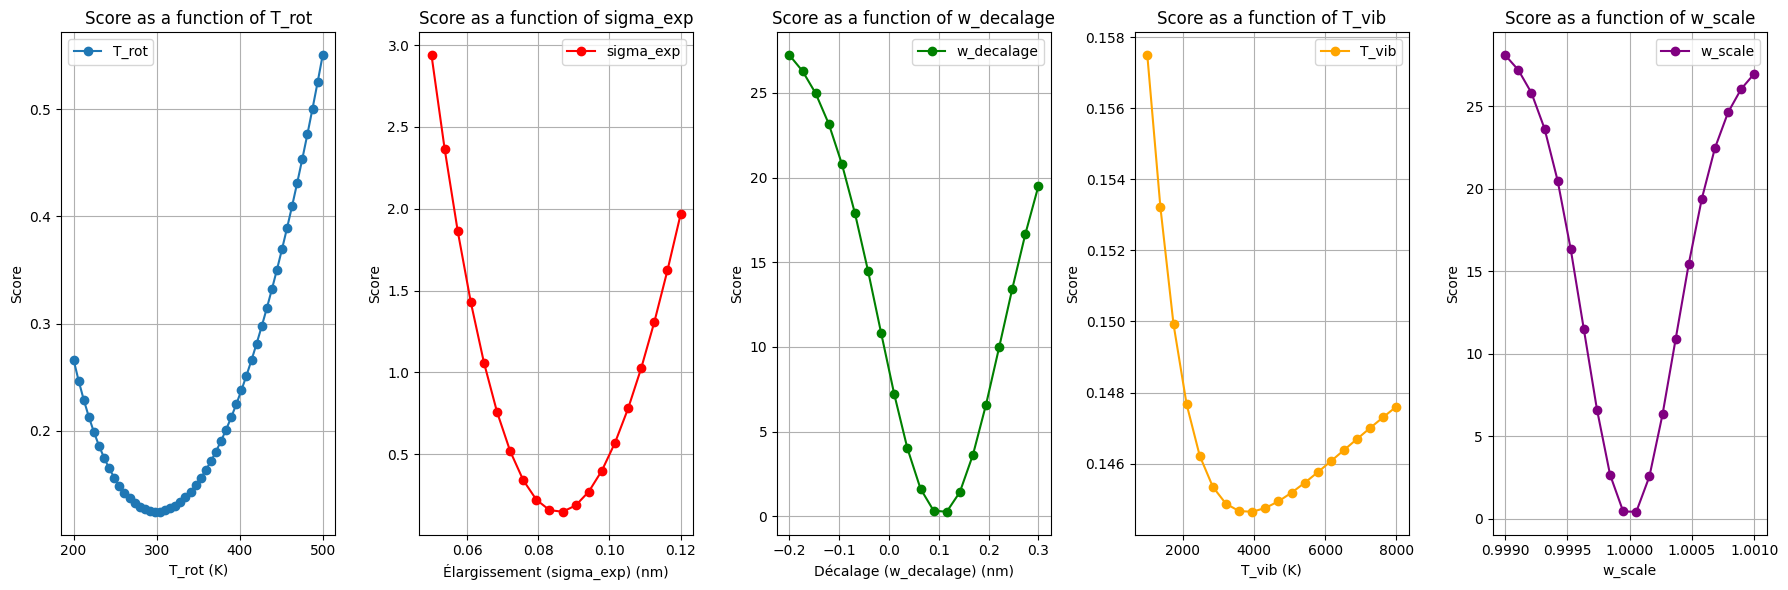

In [27]:
# Calculer les scores pour chaque valeur de T_rot
T_rot_range = np.linspace(200, 500, 50)
sigma_exp_range = np.linspace(0.05, 0.12, 20)
w_decalage_range = np.linspace(-0.2, 0.3, 20)
T_vib_range = np.linspace(1_000, 8_000, 20)
w_scale_range = np.linspace(0.999, 1.001, 20)

scores_T_rot = np.zeros_like(T_rot_range)
scores_sigma_exp = np.zeros_like(sigma_exp_range)
scores_w_decalage = np.zeros_like(w_decalage_range)
scores_T_vib = np.zeros_like(T_vib_range)
scores_w_scale = np.zeros_like(w_scale_range)

for idx, T_rot in enumerate(T_rot_range):
    scores_T_rot[idx] = utils.compute_score_fit(
        datas[0, :, 1],
        sim.get_whole_spectrum(scale_factor[i]*datas[0, :, 0]+decalage_sim[i], T_el=1_000, T_vib=T_vib_sim[i], T_rot=T_rot, sigma_exp=elargissement_sim[i])
    )

for idx, sigma_exp in enumerate(sigma_exp_range):
    scores_sigma_exp[idx] = utils.compute_score_fit(
        datas[0, :, 1],
        sim.get_whole_spectrum(scale_factor[i]*datas[0, :, 0]+decalage_sim[i], T_el=1_000, T_vib=T_vib_sim[i], T_rot=T_rot_sim[i], sigma_exp=sigma_exp)
    )

for idx, w_decalage in enumerate(w_decalage_range):
    scores_w_decalage[idx] = utils.compute_score_fit(
        datas[0, :, 1],
        sim.get_whole_spectrum(scale_factor[i]*datas[0, :, 0]+w_decalage, T_el=1_000, T_vib=T_vib_sim[i], T_rot=T_rot_sim[i], sigma_exp=elargissement_sim[i])
    )
    
for idx, T_vib in enumerate(T_vib_range):
    scores_T_vib[idx] = utils.compute_score_fit(
        datas[0, :, 1],
        sim.get_whole_spectrum(scale_factor[i]*datas[0, :, 0]+decalage_sim[i], T_el=1_000, T_vib=T_vib, T_rot=T_rot_sim[i], sigma_exp=elargissement_sim[i])
    )
    
for idx, w_scale in enumerate(w_scale_range):
    scores_w_scale[idx] = utils.compute_score_fit(
        datas[0, :, 1],
        sim.get_whole_spectrum(w_scale*datas[0, :, 0]+decalage_sim[i], T_el=1_000, T_vib=T_vib_sim[i], T_rot=T_rot_sim[i], sigma_exp=elargissement_sim[i])
    )

# Tracer le graphe
fig, axs = plt.subplots(1, 5, figsize=(18, 6))

axs[0].plot(T_rot_range, scores_T_rot, marker='o', label="T_rot")
axs[0].set_xlabel("T_rot (K)")
axs[0].set_ylabel("Score")
axs[0].set_title("Score as a function of T_rot")
axs[0].grid()
axs[0].legend()

axs[1].plot(sigma_exp_range, scores_sigma_exp, marker='o', label="sigma_exp", color='red')
axs[1].set_xlabel("Élargissement (sigma_exp) (nm)")
axs[1].set_ylabel("Score")
axs[1].set_title("Score as a function of sigma_exp")
axs[1].grid()
axs[1].legend()

axs[2].plot(w_decalage_range, scores_w_decalage, marker='o', label="w_decalage", color='green')
axs[2].set_xlabel("Décalage (w_decalage) (nm)")
axs[2].set_ylabel("Score")
axs[2].set_title("Score as a function of w_decalage")
axs[2].grid()
axs[2].legend()

axs[3].plot(T_vib_range, scores_T_vib, marker='o', label="T_vib", color='orange')
axs[3].set_xlabel("T_vib (K)")
axs[3].set_ylabel("Score")
axs[3].set_title("Score as a function of T_vib")
axs[3].grid()
axs[3].legend()

axs[4].plot(w_scale_range, scores_w_scale, marker='o', label="w_scale", color='purple')
axs[4].set_xlabel("w_scale")
axs[4].set_ylabel("Score")
axs[4].set_title("Score as a function of w_scale")
axs[4].grid()
axs[4].legend()


plt.tight_layout()
plt.savefig("./res/scores_function.png", dpi=300, bbox_inches='tight')
plt.show()


# <a id='toc2_'></a>[Conclusion](#toc0_)

|  Spectre  | Température vibrationnelle (K) | Température rotationnelle (K) - méthode analytique | Température rotationnelle (K) - fit simulation |
| :-------: | :----------------------------: | :------------------------------------------------: | :--------------------------------------------: |
| Spectre 1 |              808               |                      302 ±14                       |                      262                       |
| Spectre 2 |              825               |                      312 ± 8                       |                      273                       |
| Spectre 3 |              826               |                      363 ± 16                      |                      303                       |


In [28]:
data = {
    'Spectre': ['Spectre 1', 'Spectre 2', 'Spectre 3'],
    'T_vib (K)': T_vib_ratio,
    'T_vib (K) - fit simulation': [f"{t:.0f}" for t in T_vib_sim],
    'T_rot (K) - R branch': [f"{t[0]:.0f} +/- {t[1]:.0f}" for t in T_rot_R_branch],
    'T_rot (K) - fit simulation': [f"{t:.0f}" for t in T_rot_sim],
    'Broadening (nm)': [f"{e:.3f}" for e in elargissement_sim],
    'WDeviation (nm)': [f"{d:.3f}" for d in decalage_sim],
}

df = pd.DataFrame(data)
# print(df.to_markdown(index=False, tablefmt="grid"))
df  

,Spectre,T_vib (K),T_vib (K) - fit simulation,T_rot (K) - R branch,T_rot (K) - fit simulation,Broadening (nm),WDeviation (nm)
0,Spectre 1,5167.445272,3441,302 +/- 14,259,0.086,0.104
1,Spectre 2,5941.785469,3704,312 +/- 8,274,0.086,0.102
2,Spectre 3,5983.399292,5626,363 +/- 16,317,0.085,0.099
